In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.utils import to_categorical

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
train_df=pd.read_csv('datasets/dogs_vs_cats-train.csv')
validate_df=pd.read_csv('datasets/dogs_vs_cats-val.csv')

In [4]:
train_df

,Unnamed: 0,filename,category
0,0,datasets/dogs_vs_cats/dog.4252.jpg,dog
1,1,datasets/dogs_vs_cats/dog.16.jpg,dog
2,2,datasets/dogs_vs_cats/cat.814.jpg,cat
3,3,datasets/dogs_vs_cats/dog.3807.jpg,dog
4,4,datasets/dogs_vs_cats/cat.4868.jpg,cat
...,...,...,...
18692,18692,datasets/dogs_vs_cats/cat.5128.jpg,cat
18693,18693,datasets/dogs_vs_cats/cat.8671.jpg,cat
18694,18694,datasets/dogs_vs_cats/dog.6321.jpg,dog
18695,18695,datasets/dogs_vs_cats/dog.3316.jpg,dog


In [5]:
validate_df

,Unnamed: 0,filename,category
0,0,datasets/dogs_vs_cats/cat.5394.jpg,cat
1,1,datasets/dogs_vs_cats/cat.10625.jpg,cat
2,2,datasets/dogs_vs_cats/dog.4223.jpg,dog
3,3,datasets/dogs_vs_cats/dog.9508.jpg,dog
4,4,datasets/dogs_vs_cats/cat.9569.jpg,cat
...,...,...,...
6298,6298,datasets/dogs_vs_cats/dog.4194.jpg,dog
6299,6299,datasets/dogs_vs_cats/cat.8834.jpg,cat
6300,6300,datasets/dogs_vs_cats/dog.339.jpg,dog
6301,6301,datasets/dogs_vs_cats/dog.980.jpg,dog


In [6]:
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization

model=Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [10]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

In [11]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 None,x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    None, 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 18697 validated image filenames belonging to 2 classes.
Found 6303 validated image filenames belonging to 2 classes.


In [12]:
epochs=20
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/20
1246/1246 [==============================] - 164s 121ms/step - loss: 1.0032 - accuracy: 0.5793 - val_loss: 0.6549 - val_accuracy: 0.6857
Epoch 2/20
1246/1246 [==============================] - 143s 115ms/step - loss: 0.5711 - accuracy: 0.7081 - val_loss: 0.5774 - val_accuracy: 0.7530
Epoch 3/20
1246/1246 [==============================] - 144s 116ms/step - loss: 0.5022 - accuracy: 0.7592 - val_loss: 0.4189 - val_accuracy: 0.8149
Epoch 4/20
1246/1246 [==============================] - 144s 116ms/step - loss: 0.4709 - accuracy: 0.7810 - val_loss: 1.0628 - val_accuracy: 0.6011
Epoch 5/20
1246/1246 [==============================] - 144s 116ms/step - loss: 0.4471 - accuracy: 0.7950 - val_loss: 2.0140 - val_accuracy: 0.6163

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/20
1246/1246 [==============================] - 144s 116ms/step - loss: 0.4017 - accuracy: 0.8197 - val_loss: 0.4519 - val_accuracy: 0.8267
Epoch 7/20
1246/1246 [=========

Text(0.5, 1.0, 'Training and validation loss')

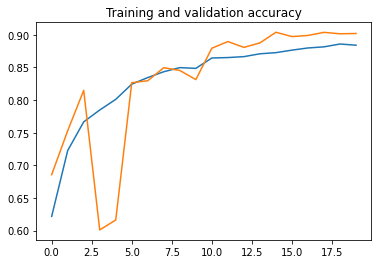

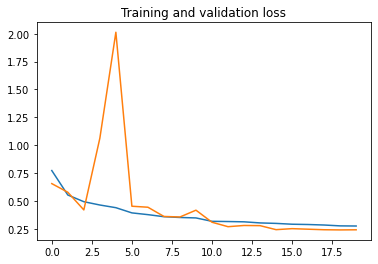

In [21]:
import matplotlib.pyplot as plt
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]
epochs   = range(len(acc))

plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [ ]:
!mkdir -p models/1
model.save("models/1")